# Phone taped to a bicycle crank Kalman filter testing
Jotham Gates

## Forward
The phone taped to a bicycle crank knows where it likely is at all times. It knows this because it knows where it probably isn't. By subtracting where thinks it is from where it likely isn't, or where it hopefully isn't from where it is (whichever is greater), it obtains a difference, or deviation. The guidance subsystem uses deviations to generate corrective commands to drive the output from the phone taped to a bicycle crank from a position where it isn't to a position where it might, and arriving at a position where it wasn't, it now is. Consequently, the position where it is likely, is now the position that it wasn't, and it follows that the position that it thought it was, is now the position that it isn't with a high degree of confidence.

In the event that the position that it is in is not the position that it wasn't, the system has acquired a variation, the variation being the difference between where the phone taped to a bicycle crank is, and where it wasn't. If variation is considered to be a significant factor, like when the rider rides off a cliff, it too may be corrected by the Kalman filter. However, the phone taped to a bicycle crank must also know where it was.
The phone taped to a bicycle crank's Kalman filter works as follows. Because a variation has modified some of the information the phone taped to a bicycle crank has obtained, it is not sure just where it is. However, it is sure where it isn't, within reason, and it knows where it was. It now subtracts where it should be from where it wasn't, or vice-versa, and by differentiating this from the algebraic sum of where it shouldn't be, and where it was, it is able to obtain the deviation and its variation, which is called error.

## Imports and setup

In [1]:
# Imports and setup
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from sympy.stats import Normal, cdf, density, Binomial, ContinuousRV, DiscreteRV, P, E
import cmath as cm
from IPython.display import display, Markdown
from enum import Enum
import pandas as pd

sp.init_printing()
# %matplotlib widget
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

## Importing and converting times to a convenient format
- Looks like the phone went from right foot forward ($x=+, y=0, z=0$) to right foot up ($x=0, y=+, z=0$) at $t=61$.
- Also note the drift in the $x$ and $y$ axis at high speeds just before $t=200s$ due to the accelerometer not being in the centre of rotation.

In [2]:
def plot_xyz(table, label, title, show_x=True, show_y=True, show_z=True):
    plt.close()
    plt.figure()
    # Being lazy and evil with if statements
    show_x and plt.plot(table["time"].values, table["x"].values, "r", label="$x$")
    show_y and plt.plot(table["time"].values, table["y"].values, "g", label="$y$")
    show_z and plt.plot(table["time"].values, table["z"].values, "b", label="$z$")
    plt.legend()
    plt.xlabel("Time [$s$]")
    plt.ylabel(label)
    plt.title(title)
    plt.show()

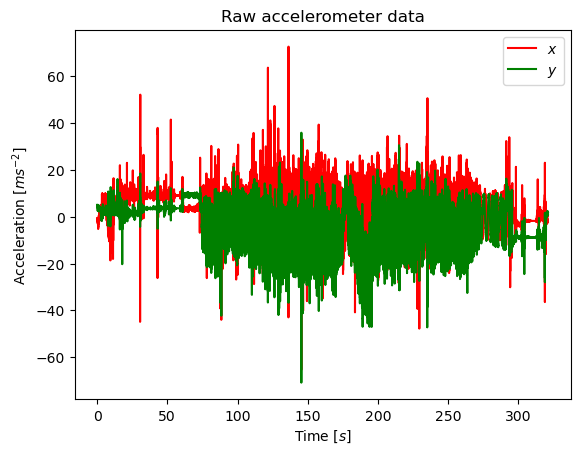

In [3]:
# accel = pd.read_csv("./AccelerometerUncalibrated.csv")
accel = pd.read_csv("./AccelerometerUncalibrated.csv")
offset = accel["time"].values[0]
accel["time"] = (accel["time"] - offset) / 1e9
accel.drop('seconds_elapsed', axis=1, inplace=True)
plot_xyz(accel, "Acceleration [$ms^{-2}$]", "Raw accelerometer data", show_z=False)

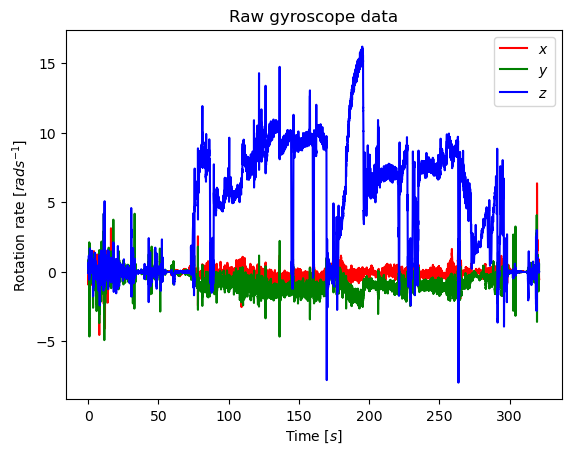

In [6]:
gyro = pd.read_csv("./GyroscopeUncalibrated.csv")
gyro["time"] = (gyro["time"] - offset) / 1e9
gyro.drop('seconds_elapsed', axis=1, inplace=True)
plot_xyz(gyro, "Rotation rate [$rad s^{-1}$]", "Raw gyroscope data")

### Check the timestamps match between the gyroscope and accelerometer

In [7]:
times = accel["time"].values

array([0.00000000e+00, 2.00020000e-03, 3.97420000e-03, ...,
       3.21042065e+02, 3.21044066e+02, 3.21046065e+02])

In [8]:
if not np.alltrue(gyro["time"].values == accel["time"].values):
    print("Accelerometer and gyroscope have different times")
else:
    print("Accelerometer and gyroscope have the same times")

Accelerometer and gyroscope have the same times


### Merge into one table

In [9]:
# Merge into one table.
data = accel.merge(gyro, how="inner", on="time", suffixes=("_accel", "_gyro"))

,time,z_accel,y_accel,x_accel,z_gyro,y_gyro,x_gyro
0,0.000000,8.250718,4.996998,-0.718261,-0.048869,0.160658,-0.093462
1,0.002000,8.255507,4.982633,-0.730232,-0.054367,0.158214,-0.095295
2,0.003974,8.245930,4.956297,-0.739808,-0.065363,0.157603,-0.093462
3,0.005974,8.243536,4.939538,-0.742203,-0.065363,0.157603,-0.093462
4,0.007983,8.233959,4.922778,-0.751779,-0.073304,0.160047,-0.090408
...,...,...,...,...,...,...,...
160521,321.038065,10.055946,1.632846,0.502782,-0.020769,0.450208,-0.567494
160522,321.040065,10.122984,1.666364,0.462081,-0.015272,0.491136,-0.579100
160523,321.042065,10.170868,1.656788,0.469264,-0.014661,0.511905,-0.580933
160524,321.044066,10.271424,1.618480,0.505177,-0.008552,0.529009,-0.572992


## Offsets of the IMU in the phone relative to the centre of the axle
Guess based on [this teardown](https://www.ifixit.com/Teardown/Samsung+Galaxy+S10+and+S10e+Teardown/120331).
For an S10e, the IMU appears to be near the camera flash.

In [10]:
# In metres
imu_length_offset = 0.115
imu_width_offset = 0.02
imu_radius_offset = np.sqrt(imu_length_offset**2 + imu_width_offset**2)

## Calculating angle based on acceleration
This uses the distance offsets and gyroscope-based velocity to correct for centripedal acceleration. This is because the IMU is not at the centre of rotation.

These calculations assume that the accelerometer is rotating entirely around the $z$ axis. This means that all $z$ axis acceleration is ignored.

In [11]:
data["x_corrected"] = data["x_accel"] - imu_width_offset*(data["z_gyro"]**2)
data["y_corrected"] = data["y_accel"] + imu_length_offset*(data["z_gyro"]**2)
data["centripedal_accel"] = imu_radius_offset*(data["z_gyro"]**2)

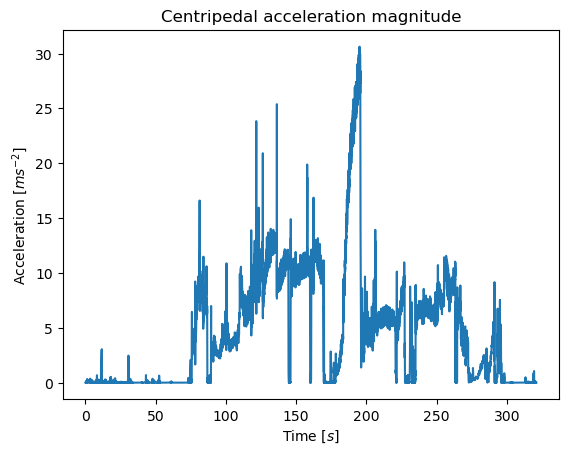

In [12]:
plt.close()
plt.figure()
plt.plot(data["time"].values, data["centripedal_accel"].values)
plt.xlabel("Time [$s$]")
plt.ylabel("Acceleration [$ms^{-2}$]")
# plt.legend()
plt.title("Centripedal acceleration magnitude")
plt.show()

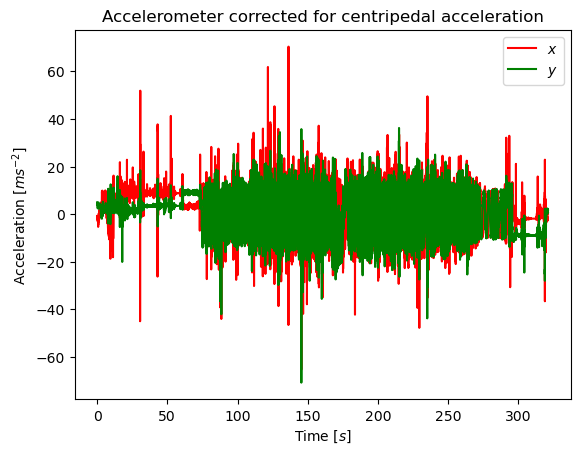

In [13]:
plt.close()
plt.figure()
plt.plot(data["time"].values, data["x_corrected"].values, "r", label="$x$")
plt.plot(data["time"].values, data["y_corrected"].values, "g", label="$y$")
plt.legend()
plt.xlabel("Time [$s$]")
plt.ylabel("Acceleration [$ms^{-2}$]")
plt.title("Accelerometer corrected for centripedal acceleration")
plt.show()

In [14]:
# data["theta_accel"] = np.arctan
angle = np.arctan(np.abs(data["y_corrected"] / data["x_corrected"]))
data.loc[(data["x_corrected"] >= 0) & (data["y_corrected"] >= 0), "theta_accel"] = angle # First quadrant
data.loc[(data["x_corrected"] < 0) & (data["y_corrected"] >= 0), "theta_accel"] = np.pi - angle # Second quadrant
data.loc[(data["x_corrected"] < 0) & (data["y_corrected"] < 0), "theta_accel"] = -np.pi + angle # Third quadrant
data.loc[(data["x_corrected"] >= 0) & (data["y_corrected"] < 0), "theta_accel"] = -angle # Fourth quadrant
data["theta_accel"] *= -1

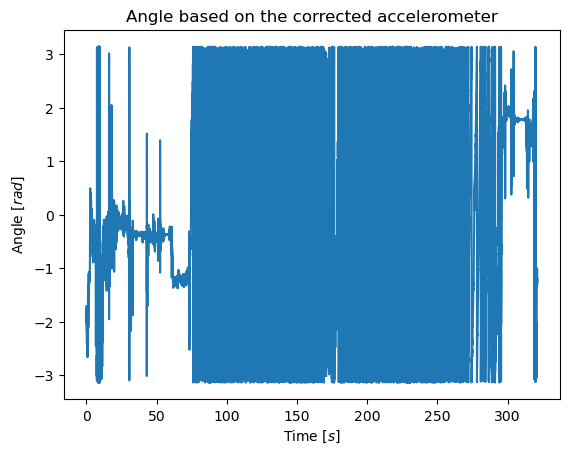

In [15]:
plt.close()
plt.figure()
plt.plot(data["time"].values, data["theta_accel"].values)
plt.xlabel("Time [$s$]")
plt.ylabel("Angle [$rad$]")
plt.title("Angle based on the corrected accelerometer")
plt.show()

In [16]:
data

,time,z_accel,y_accel,x_accel,z_gyro,y_gyro,x_gyro,x_corrected,y_corrected,centripedal_accel,theta_accel
0,0.000000,8.250718,4.996998,-0.718261,-0.048869,0.160658,-0.093462,-0.718308,4.997273,0.000279,-1.713559
1,0.002000,8.255507,4.982633,-0.730232,-0.054367,0.158214,-0.095295,-0.730291,4.982973,0.000345,-1.716318
2,0.003974,8.245930,4.956297,-0.739808,-0.065363,0.157603,-0.093462,-0.739894,4.956788,0.000499,-1.718971
3,0.005974,8.243536,4.939538,-0.742203,-0.065363,0.157603,-0.093462,-0.742288,4.940029,0.000499,-1.719940
4,0.007983,8.233959,4.922778,-0.751779,-0.073304,0.160047,-0.090408,-0.751887,4.923396,0.000627,-1.722343
...,...,...,...,...,...,...,...,...,...,...,...
160521,321.038065,10.055946,1.632846,0.502782,-0.020769,0.450208,-0.567494,0.502774,1.632895,0.000050,-1.272105
160522,321.040065,10.122984,1.666364,0.462081,-0.015272,0.491136,-0.579100,0.462076,1.666391,0.000027,-1.300301
160523,321.042065,10.170868,1.656788,0.469264,-0.014661,0.511905,-0.580933,0.469259,1.656812,0.000025,-1.294795
160524,321.044066,10.271424,1.618480,0.505177,-0.008552,0.529009,-0.572992,0.505175,1.618489,0.000009,-1.268251


## Kalman filter working out
- https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/ (My current favourite, many of the formulas are copied and pasted from this website,)
- https://medium.com/analytics-vidhya/kalman-filters-a-step-by-step-implementation-guide-in-python-91e7e123b968
- https://thekalmanfilter.com/kalman-filter-explained-simply/
- https://bps-space.github.io/control-theory/

$$
\begin{aligned}
\hat{\mathbf{x}} &= \left[ \begin{matrix}\theta \\ \omega \end{matrix} \right] \\
\mathbf{P}_k &= 
\begin{bmatrix} 
\Sigma_{\theta \theta} & \Sigma_{\theta \omega} \\ 
\Sigma_{\theta \omega} & \Sigma_{\omega \omega} \\ 
\end{bmatrix} 
\end{aligned}
$$

Where:
- $\hat{\mathbf{x}}$ is the state estimate.
- $\mathbf{P}_k$ is the covariance matrix (uncertaincy)

### Prediction step
$$
\begin{split} 
\theta_k &= \theta_{k-1} + \Delta t &\omega_{k-1} \\ 
\omega_k &= &\omega_{k-1}
\end{split}
$$

In matrix form:
$$
\begin{align} 
\mathbf{\hat{x}}_k &= \begin{bmatrix} 
1 & \Delta t \\ 
0 & 1 
\end{bmatrix} \mathbf{\hat{x}}_{k-1} \\ 
&= \mathbf{F}_k \mathbf{\hat{x}}_{k-1}
\end{align}
$$

In [17]:
# NOTE: We need to correct for theta overflowing.

$$
\begin{equation} 
\begin{split} 
\color{deeppink}{\mathbf{\hat{x}}_k} &= \mathbf{F}_k \color{royalblue}{\mathbf{\hat{x}}_{k-1}} + \mathbf{B}_k \color{darkorange}{\vec{\mathbf{u}_k}} \\ 
\color{deeppink}{\mathbf{P}_k} &= \mathbf{F_k} \color{royalblue}{\mathbf{P}_{k-1}} \mathbf{F}_k^T + \color{mediumaquamarine}{\mathbf{Q}_k} 
\end{split} 
\end{equation}
$$

- We don't have any inputs to the system that we can easily model and want to keep things simple, so $\mathbf{B}_k \color{darkorange}{\vec{\mathbf{u}_k}} = 0$.
- $\color{mediumaquamarine}{\mathbf{Q}_k}$ is additional uncertainty from the environment.

### Update step

$$
\begin{split} 
\color{royalblue}{\mathbf{\hat{x}}_k’} &= \color{fuchsia}{\mathbf{\hat{x}}_k} + \color{purple}{\mathbf{K}’} ( \color{yellowgreen}{\vec{\mathbf{z}_k}} – \color{fuchsia}{\mathbf{H}_k \mathbf{\hat{x}}_k}) \\ 
\color{royalblue}{\mathbf{P}_k’} &= \color{deeppink}{\mathbf{P}_k} – \color{purple}{\mathbf{K}’} \color{deeppink}{\mathbf{H}_k \mathbf{P}_k} 
\end{split} 
$$


Where the Kalman gain, $\color{purple}{\mathbf{K}’}$ is:
$$
\color{purple}{\mathbf{K}’} = \color{deeppink}{\mathbf{P}_k \mathbf{H}_k^T} ( \color{deeppink}{\mathbf{H}_k \mathbf{P}_k \mathbf{H}_k^T} + \color{mediumaquamarine}{\mathbf{R}_k})^{-1} 
$$

### Sympy
#### Prediction

In [18]:
# x and p
theta, omega = sp.symbols("\\theta_{k-1} \\omega_{k-1}")
p_theta, p_omega, p_theta_omega = sp.symbols("\\Sigma_{\\theta\\theta} \\Sigma_{\\omega\\omega} \\Sigma_{\\theta\\omega}")
x = sp.Matrix([theta, omega])
p = sp.Matrix([[p_theta, p_theta_omega], [p_theta_omega, p_omega]])

# Prediction matrix
t = sp.symbols("\Delta{t}_{k}")
f = sp.Matrix([[1, t], [0, 1]])

# Environmental uncertainty
q_theta, q_omega, q_theta_omega = sp.symbols("Q_{\\theta\\theta} Q_{\\omega\\theta} Q_{\\theta\\omega}")
q = sp.Matrix([[q_theta, q_theta_omega], [q_theta_omega, q_omega]])

# x prediction
x_predict = f*x

⎡\Delta{t}_{k}⋅\omega_{k-1} + \theta_{k-1}⎤
⎢                                         ⎥
⎣              \omega_{k-1}               ⎦

In [19]:
# p prediction
p_predict = f*p*sp.transpose(f) + q

⎡Q_{\theta\theta} + \Delta{t}_{k}⋅\Sigma_{\theta\omega} + \Delta{t}_{k}⋅(\Delt
⎢                                                                             
⎣                                       Q_{\theta\omega} + \Delta{t}_{k}⋅\Sigm

a{t}_{k}⋅\Sigma_{\omega\omega} + \Sigma_{\theta\omega}) + \Sigma_{\theta\theta
                                                                              
a_{\omega\omega} + \Sigma_{\theta\omega}                                      

}  Q_{\theta\omega} + \Delta{t}_{k}⋅\Sigma_{\omega\omega} + \Sigma_{\theta\ome
                                                                              
                      Q_{\omega\theta} + \Sigma_{\omega\omega}                

ga}⎤
   ⎥
   ⎦

#### Refininement

In [20]:
h = sp.Matrix([[1, 0], [0, 1]])
ht = sp.transpose(h)

# Measurement uncertainty
r_theta, r_omega, r_theta_omega = sp.symbols("R_{\\theta\\theta} R_{\\omega\\omega} R_{\\theta\\omega}")
r = sp.Matrix([[r_theta, r_theta_omega], [r_theta_omega, r_omega]])

# Calculate k prime
k_prime = p_predict*ht*(h*p_predict*ht + r).inverse()

⎡                                                                             
⎢                                                                             
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢Q_{\omega\theta}⋅Q_{\theta\theta} + Q_{\omega\theta}⋅R_{\theta\theta} + Q_{\o
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎣Q_{\omega\theta}⋅Q_{\theta\theta} + Q_{\omega\theta}⋅R_{\theta\theta} + Q_{\o

                                                                              
                                                   

In [21]:
# Measured
z_theta, z_omega = sp.symbols("z_{\\theta} z_{\\omega}")
z = sp.Matrix([z_theta, z_omega])
x_prime = x_predict + k_prime * (z - h*x_predict)
x_prime = sp.simplify(x_prime)

⎡                              ⎛                                              
⎢- (\omega_{k-1} - z_{\omega})⋅⎝(Q_{\theta\omega} + \Delta{t}_{k}⋅\Sigma_{\ome
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                                                                             

                                   ⎛                                          
ga\omega} + \Sigma_{\theta\omega})⋅⎝Q_{\theta\theta

In [22]:
p_prime = p_predict - k_prime*h*p_predict
p_prime = sp.simplify(p_prime)

⎡                                                                             
⎢Q_{\omega\theta}⋅Q_{\theta\theta}⋅R_{\theta\theta} + Q_{\omega\theta}⋅R_{\the
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                   Q_{\omega\
⎢                                                                   ──────────
⎢                                                                             
⎣                                                                             

                       2                                                      
ta\theta}⋅\Delta{t}_{k} ⋅\Sigma_{\omega\omega} + 2⋅

In [23]:
subs_list = [
    (p_theta, 10e3),
    (p_theta_omega, 10e3),
    (p_omega, 10e3),
    (q_theta, 0.1),
    (q_omega, 2),
    (q_theta_omega, 1),
    (r_theta, 1),
    (r_theta_omega, 0.2),
    (r_omega, 0.1)
]
sp.simplify(x_prime.subs(subs_list))

⎡                      2                                   2                  
⎢- 2000.0⋅\Delta{t}_{k} ⋅z_{\omega} + 21000.0⋅\Delta{t}_{k} ⋅z_{\theta} + 2001
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                 2                           
⎢                            20000.0⋅\Delta{t}_{k} ⋅z_{\omega} + 1000.29999999
⎢                            ─────────────────────────────────────────────────
⎢                                                                             
⎣                                                                             

                                                                              
.85999999464⋅\Delta{t}_{k}⋅\omega_{k-1} - 2000.0⋅\D

### Wrap up

Overview diagram stolen from [here](https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/)
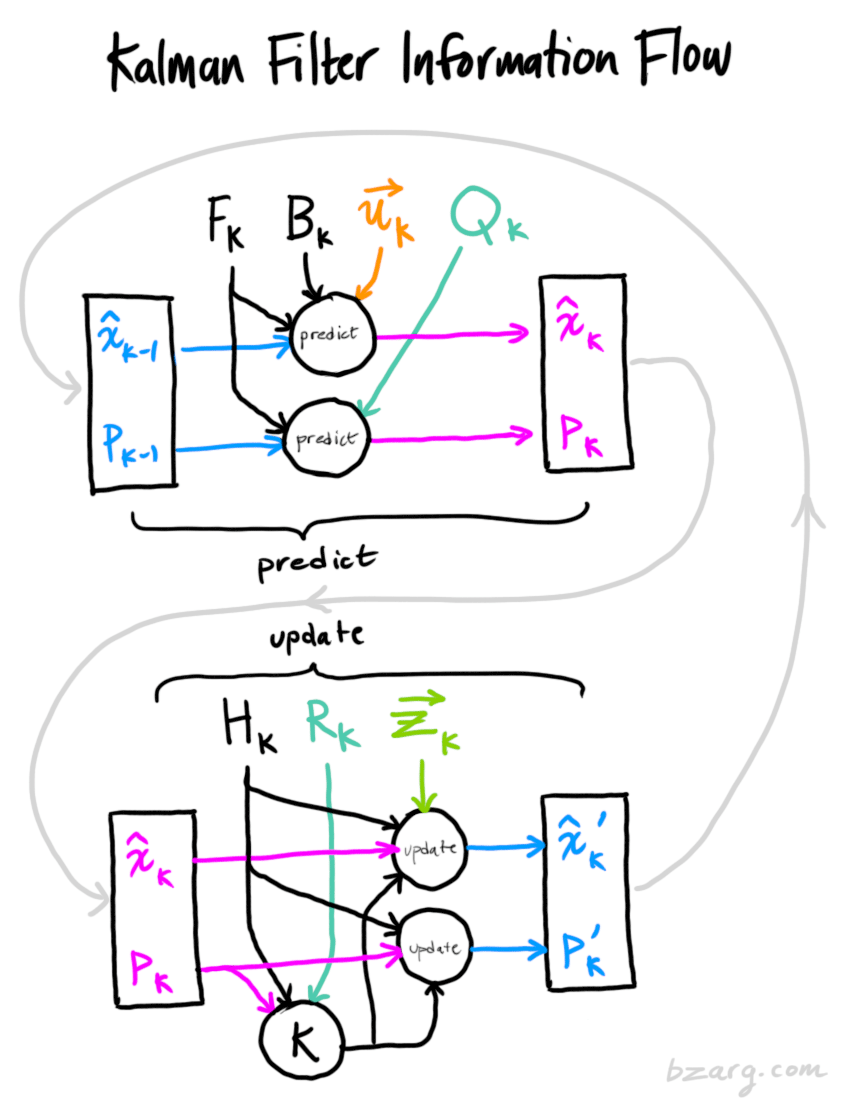

### Implementation

In [24]:
def limit_angles(value):
    # if value > np.pi:
    #     value -= 2*np.pi
    # elif value <= -np.pi:
    #     value += 2*np.pi
    # return value
    value = value % (2*np.pi)
    if value > np.pi:
        value -= 2*np.pi
    
    return value

def angle_diff(vector1, vector2):
    """Subtracts two thera-omega vectors from each other, wrapping around to use the shortest side of the circle.

    Args:
        vector1 (np.ndarray): The first vector to subtract.
        vector2 (np.ndarray): The second vector to subtract

    Returns:
        np.ndarray: vector1-vector2 taking into accound the cyclical nature of theta.
    """
    difference = vector1[0] - vector2[0]
    if abs(difference[0]) > np.pi:
        # Over 1/2 circle, can go around the other way.
        difference = 2*np.pi - difference
        
    result = np.array([
        difference,
        vector1[1] - vector2[1]
    ])
    return result


def kalman_step(x_prev:np.ndarray, p_prev:np.ndarray, time:float, env_uncertainty:np.ndarray, measured:np.ndarray, meas_uncertainty:np.ndarray):
    """A Kalman filter modified to work with angles.

    Args:
        x_prev (np.ndarray): The previous state as a 2 row, 1 column matrix (position on top, angular velocity below).
        p_prev (np.ndarray): The previous covariance matrix.
        time (float): The time step from the last call.
        env_uncertainty (np.ndarray): The environmental uncertainty covariance matrix.
        measured (np.ndarray): The measured values at this step.
        meas_uncertainty (np.ndarray): The covariance matrix representing the measured values' uncertainty.

    Returns:
        Tuple: the current position and current covariance matrix.
    """
    x_prev = x_prev.reshape(2, 1)
    # p_prev = p_prev.reshape(2, 1)
    # env_uncertainty = env_uncertainty.reshape(2, 1)
    measured = measured.reshape(2, 1)
    # meas_uncertainty = meas_uncertainty.reshape(2, 1)
    # Prediction
    fk = np.array([
        [1, time],
        [0, 1]
    ])
    x_predict = np.matmul(fk, x_prev) # Ignoring Bk u

    # Limit theta
    x_predict[0] = limit_angles(x_predict[0])
    
    p_predict = np.matmul(np.matmul(fk, p_prev), fk.transpose()) + env_uncertainty
    # return x_predict, p_predict
    # print(f"{p_predict=}")
    # Update
    hk = np.array([
        [1, 0],
        [0, 1]
    ])
    k_prime = p_predict.dot(hk.transpose()).dot(
        np.linalg.inv(
            hk.dot(p_predict).dot(hk.transpose()) + meas_uncertainty
        )
    )
    # temp = np.dot(np.dot(hk, p_predict), hk.T) + meas_uncertainty
    # k_prime = np.dot(np.dot(p_predict, hk.T), np.linalg.inv(temp))   
    # x_prime = x_predict + k_prime.dot(measured - hk.dot(x_predict))
    x_prime = x_predict + k_prime.dot(angle_diff(measured, hk.dot(x_predict)))
    p_prime = p_predict - k_prime.dot(hk).dot(p_predict)

    # temp2 = measured - np.dot(hk, x_predict)  
    # x_prime = x_predict + np.dot(k_prime, temp2)

    # I = np.eye(p_predict.shape[0])
    # p_prime = np.dot(np.dot(I - np.dot(k_prime, hk), p_predict), (I - np.dot(k_prime, hk)).T) + np.dot(np.dot(k_prime, meas_uncertainty), k_prime.T)

    x_prime[0] = limit_angles(x_prime[0])

    return x_predict, x_prime, p_prime

# Example
# kalman_step(
#     np.array([0, 10]),
#     np.array([
#         [0, 100],
#         [100, 0]
#     ]),
#     0.2,
#     np.array([10, 20]),
#     np.array([2, 13]),
#     np.array([0.1, 0.5])
# )

#### Old stuff and testing (ignore)

In [25]:
x = np.array([1.97, 0.2])
p= np.array([
    [1, 0],
    [0, 1]
])

r= np.array([[0.02, 0], [0, 0.03]])
q = np.array([[0.03, 0], [0, 0.03]])
meas = np.array([
    [2, 0.19],
    [2.04, 0.2],
    [2.08, 0.21],
    [2.12, 0.19],
    [2.16, 0.21],
    [2.2, 0.2],
    [2.24, 0.2],
    [2.3, 0.2]
])
for i in range(meas.shape[0]):
    x_pred, x, p = kalman_step(
        x,
        p,
        0.2,
        q,
        meas[i, :],
        r
    )
    print(f"{i}:\n{meas[i, :]=},\n{x_pred=}, \n{x=}, \n{p=}\n")

0:
meas[i, :]=array([2.  , 0.19]),
x_pred=array([[2.01],
       [0.2 ]]), 
x=array([[2.0001542 ],
       [0.19023938]]), 
p=array([[0.01961987, 0.00010758],
       [0.00010758, 0.02912049]])

1:
meas[i, :]=array([2.04, 0.2 ]),
x_pred=array([[2.03820208],
       [0.19023938]]), 
x=array([[2.03967394],
       [0.1967469 ]]), 
p=array([[0.01432084, 0.00056699],
       [0.00056699, 0.01984471]])

2:
meas[i, :]=array([2.08, 0.21]),
x_pred=array([[2.07902332],
       [0.1967469 ]]), 
x=array([[2.07993123],
       [0.20502628]]), 
p=array([[0.01385407, 0.00052372],
       [0.00052372, 0.01868349]])

3:
meas[i, :]=array([2.12, 0.19]),
x_pred=array([[2.12093649],
       [0.20502628]]), 
x=array([[2.12003805],
       [0.19572605]]), 
p=array([[0.01380615, 0.00050306],
       [0.00050306, 0.01852091]])

4:
meas[i, :]=array([2.16, 0.21]),
x_pred=array([[2.15918326],
       [0.19572605]]), 
x=array([[2.15998391],
       [0.20454773]]), 
p=array([[0.01380064, 0.00049825],
       [0.00049825, 0.01849

##### Implementation from online
https://www.geeksforgeeks.org/kalman-filter-in-python/

In [26]:
# import numpy as np

class KalmanFilter:
    def __init__(self, F, B, H, Q, R, x0, P0):
        self.F = F  # State transition model
        self.B = B  
        self.H = H  
        self.Q = Q  
        self.R = R  
        self.x = x0  
        self.P = P0  
    def predict(self, u):
        # Predict the state and state covariance
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x
    def update(self, z):
        # Compute the Kalman gain
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))      
        # Update the state estimate and covariance matrix
        y = z - np.dot(self.H, self.x)  
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.P.shape[0])
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)
        return self.x
# Example usage
F = np.array([[1, 1], [0, 1]]) 
B = np.array([[0.5], [1]])     
H = np.array([[1, 0]])         
Q = np.array([[1, 0], [0, 1]]) 
R = np.array([[1]])             
# Initial state and covariance
x0 = np.array([[0], [1]]) 
P0 = np.array([[1, 0], [0, 1]]) 
# Create Kalman Filter instance
kf = KalmanFilter(F, B, H, Q, R, x0, P0)
# Predict and update with the control input and measurement
u = np.array([[1]])  
z = np.array([[1]]) 
# Predict step
predicted_state = kf.predict(u)
print("Predicted state:\n", predicted_state)
# Update step
updated_state = kf.update(z)
print("Updated state:\n", updated_state)


Predicted state:
 [[1.5]
 [2. ]]
Updated state:
 [[1.125]
 [1.875]]


In [27]:
# Example usage
F = np.array([[1, 1], [0, 1]]) 
B = np.array([[0], [0]])
H = np.array([[1, 0], [0, 1]])         
Q = np.array([[1, 0], [0, 1]]) 
R = np.array([[1, 0], [0, 1]])             
# Initial state and covariance
x0 = np.array([[0], [1]]) 
P0 = np.array([[1, 0], [0, 1]]) 
# Create Kalman Filter instance
kf = KalmanFilter(F, B, H, Q, R, x0, P0)
# Predict and update with the control input and measurement
u = np.array([[0]])

# Step 1
print("Step 1")
z = np.array([[1], [1]]) 
# Predict step
predicted_state = kf.predict(u)
print("Predicted state:\n", predicted_state)
# Update step
updated_state = kf.update(z)
print("Updated state:\n", updated_state)
print("Covariance:\n", kf.P)

# Step 2
print("\nStep 2")
z = np.array([[1.5], [1]]) 
# Predict step
predicted_state = kf.predict(u)
print("Predicted state:\n", predicted_state)
# Update step
updated_state = kf.update(z)
print("Updated state:\n", updated_state)
print("Covariance:\n", kf.P)

Step 1
Predicted state:
 [[1]
 [1]]
Updated state:
 [[1.]
 [1.]]
Covariance:
 [[0.72727273 0.09090909]
 [0.09090909 0.63636364]]

Step 2
Predicted state:
 [[2.]
 [1.]]
Updated state:
 [[1.64948454]
 [0.95876289]]
Covariance:
 [[0.70103093 0.08247423]
 [0.08247423 0.59793814]]


In [28]:
x0 = np.array([[1.97], [0.2]])
P0 = np.array([
    [1, 0],
    [0, 1]
])

F = np.array([[1, 0.2], [0, 1]])
B = np.array([[0], [0]])
H = np.array([[1, 0], [0, 1]])
Q = np.array([[0.03, 0], [0, 0.03]])
R = np.array([[0.02, 0], [0, 0.03]])
meas = np.array([
    [2, 0.19],
    [2.04, 0.2],
    [2.08, 0.21],
    [2.12, 0.19],
    [2.16, 0.21],
    [2.2, 0.2],
    [2.24, 0.2],
    [2.3, 0.2],
    [2.5, 0.6]
])
kf = KalmanFilter(F, B, H, Q, R, x0, P0)
for i in range(meas.shape[0]):
    print(f"\nStep {i}:")
    print("Measured:\n", meas[i, :])
    predicted_state = kf.predict(u)
    print("Predicted state:\n", predicted_state)
    # Update step
    updated_state = kf.update(meas[i, :].reshape(2, 1))
    print("Updated state:\n", updated_state)
    print("Covariance:\n", kf.P)
    # print(f"{i}:\n{meas[i, :]=},\n{x_pred=}, \n{x=}, \n{p=}\n")


Step 0:
Measured:
 [2.   0.19]
Predicted state:
 [[2.01]
 [0.2 ]]
Updated state:
 [[2.0001542 ]
 [0.19023938]]
Covariance:
 [[0.01961987 0.00010758]
 [0.00010758 0.02912049]]

Step 1:
Measured:
 [2.04 0.2 ]
Predicted state:
 [[2.03820208]
 [0.19023938]]
Updated state:
 [[2.03967394]
 [0.1967469 ]]
Covariance:
 [[0.01432084 0.00056699]
 [0.00056699 0.01984471]]

Step 2:
Measured:
 [2.08 0.21]
Predicted state:
 [[2.07902332]
 [0.1967469 ]]
Updated state:
 [[2.07993123]
 [0.20502628]]
Covariance:
 [[0.01385407 0.00052372]
 [0.00052372 0.01868349]]

Step 3:
Measured:
 [2.12 0.19]
Predicted state:
 [[2.12093649]
 [0.20502628]]
Updated state:
 [[2.12003805]
 [0.19572605]]
Covariance:
 [[0.01380615 0.00050306]
 [0.00050306 0.01852091]]

Step 4:
Measured:
 [2.16 0.21]
Predicted state:
 [[2.15918326]
 [0.19572605]]
Updated state:
 [[2.15998391]
 [0.20454773]]
Covariance:
 [[0.01380064 0.00049825]
 [0.00049825 0.01849804]]

Step 5:
Measured:
 [2.2 0.2]
Predicted state:
 [[2.20089345]
 [0.204547

In [29]:
x0 = np.array([[1.97], [0.2]])
P0 = np.array([
    [1, 0],
    [0, 1]
])

F = np.array([[1, 0.2], [0, 1]])
B = np.array([[0], [0]])
H = np.array([[1, 0], [0, 1]])
# Q = np.array([[0.03, 0], [0, 0.03]])
Q = np.array([[0, 0], [0, 0]])
R = np.array([[0.02, 0], [0, 0.03]])
meas = np.array([
    [2, 0.19],
    [2.04, 0.2],
    [2.08, 0.21],
    [2.12, 0.19],
    [2.16, 0.21],
    [2.2, 0.2],
    [2.24, 0.2],
    [2.3, 0.2],
    [2.5, 0.6]
])
kf = KalmanFilter(F, B, H, Q, R, x0, P0)
x = x0
p = P0
for i in range(meas.shape[0]):
    print(f"\nStep {i}:")
    print("Measured:\n", meas[i, :])
    predicted_state = kf.predict(u)
    print("Predicted state:\n", predicted_state)
    print("Predicted Covariance:\n", kf.P)
    # Update step
    updated_state = kf.update(meas[i, :].reshape(2, 1))
    print("Updated state:\n", updated_state)
    print("Covariance:\n", kf.P)

    # Run with my version
    x_pred, x, p = kalman_step(
        x,
        p,
        0.2,
        Q,
        meas[i, :],
        R
    )
    print(f"\n{x=}, \n{p=}\n")


Step 0:
Measured:
 [2.   0.19]
Predicted state:
 [[2.01]
 [0.2 ]]
Predicted Covariance:
 [[1.04 0.2 ]
 [0.2  1.  ]]
Updated state:
 [[2.00015782]
 [0.19024529]]
Covariance:
 [[0.01960829 0.00011409]
 [0.00011409 0.02909298]]

x=array([[2.00015782],
       [0.19024529]]), 
p=array([[0.01960829, 0.00011409],
       [0.00011409, 0.02909298]])


Step 1:
Measured:
 [2.04 0.2 ]
Predicted state:
 [[2.03820688]
 [0.19024529]]
Predicted Covariance:
 [[0.02081765 0.00593269]
 [0.00593269 0.02909298]]
Updated state:
 [[2.03959535]
 [0.19510872]]
Covariance:
 [[0.0100552  0.00149762]
 [0.00149762 0.01454423]]

x=array([[2.03959535],
       [0.19510872]]), 
p=array([[0.0100552 , 0.00149762],
       [0.00149762, 0.01454423]])


Step 2:
Measured:
 [2.08 0.21]
Predicted state:
 [[2.0786171 ]
 [0.19510872]]
Predicted Covariance:
 [[0.01123602 0.00440647]
 [0.00440647 0.01454423]]
Updated state:
 [[2.08005857]
 [0.19996221]]
Covariance:
 [[0.00701304 0.00192707]
 [0.00192707 0.00950941]]

x=array([[2.0

## Testing on the data

In [30]:
# Lists to save data in
thetas = np.zeros(shape=(len(data), 1))
omegas = np.zeros(shape=(len(data), 1))

# Initial states
x = np.array([[0], [0]]) # Starting position.
p = np.array([[1e4, 1e4], [1e4, 1e4]]) # Initially not confident where we are.

# Constants
env_uncertainty = np.array([[0.002, 0], [0, 0.01]]) # Probably will be somewhere near here, allows a bit to account for changing in speed.
meas_uncertainty = np.array([[1e4, 0], [0, 0.1]]) # Really not confident in the accelerometer, very confident in the gyroscope.

# Run the kalmin filter
for i in range(1, len(data)): # // 3 for quicker testing
    # Calculate parameters
    prev_row = data.loc[i-1]
    cur_row = data.loc[i]
    time = cur_row["time"] - prev_row["time"]
    meas = np.array([cur_row["theta_accel"], cur_row["z_gyro"]])

    # Do the step
    _, x, p = kalman_step(x, p, time, env_uncertainty, meas, meas_uncertainty)

    # Save the results for analysis later
    thetas[i] = x[0]
    omegas[i] = x[1]

In [31]:
data["theta"] = thetas
data["omega"] = omegas

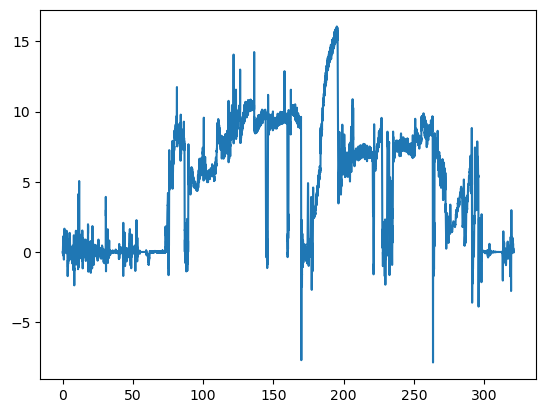

In [32]:
plt.close()
plt.figure()
plt.plot(data["time"].values, data["omega"].values)
plt.show()

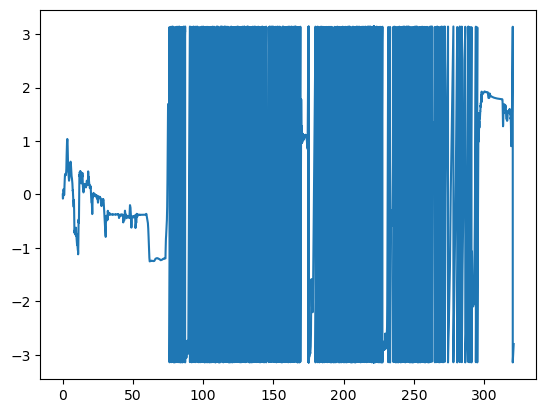

In [33]:
plt.close()
plt.figure()
plt.plot(data["time"].values, data["theta"].values)
plt.show()

## Integrating just the gyroscope

In [34]:
time_step = np.concatenate((np.array([0]), np.diff(data["time"])))
impulse = data["z_gyro"] * time_step
full_angle = impulse.cumsum()
data["theta_gyro"] = full_angle
data["theta_gyro"] -= 0.2 # Roughly zero the start
data["theta_gyro"] %= (2*np.pi)
data["theta_gyro"] -= np.pi
data

,time,z_accel,y_accel,x_accel,z_gyro,y_gyro,x_gyro,x_corrected,y_corrected,centripedal_accel,theta_accel,theta,omega,theta_gyro
0,0.000000,8.250718,4.996998,-0.718261,-0.048869,0.160658,-0.093462,-0.718308,4.997273,0.000279,-1.713559,0.000000,0.000000,2.941593
1,0.002000,8.255507,4.982633,-0.730232,-0.054367,0.158214,-0.095295,-0.730291,4.982973,0.000345,-1.716318,-0.054494,-0.054383,2.941484
2,0.003974,8.245930,4.956297,-0.739808,-0.065363,0.157603,-0.093462,-0.739894,4.956788,0.000499,-1.718971,-0.059861,-0.060142,2.941355
3,0.005974,8.243536,4.939538,-0.742203,-0.065363,0.157603,-0.093462,-0.742288,4.940029,0.000499,-1.719940,-0.061531,-0.062153,2.941224
4,0.007983,8.233959,4.922778,-0.751779,-0.073304,0.160047,-0.090408,-0.751887,4.923396,0.000627,-1.722343,-0.063887,-0.065794,2.941077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160521,321.038065,10.055946,1.632846,0.502782,-0.020769,0.450208,-0.567494,0.502774,1.632895,0.000050,-1.272105,-2.799215,-0.016917,1.989656
160522,321.040065,10.122984,1.666364,0.462081,-0.015272,0.491136,-0.579100,0.462076,1.666391,0.000027,-1.300301,-2.798576,-0.016473,1.989626
160523,321.042065,10.170868,1.656788,0.469264,-0.014661,0.511905,-0.580933,0.469259,1.656812,0.000025,-1.294795,-2.797934,-0.015983,1.989596
160524,321.044066,10.271424,1.618480,0.505177,-0.008552,0.529009,-0.572992,0.505175,1.618489,0.000009,-1.268251,-2.797271,-0.013976,1.989579


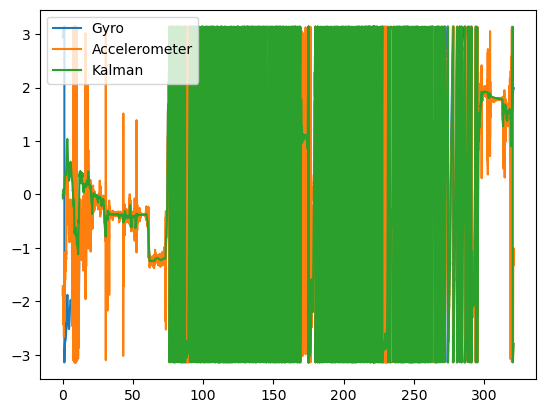

In [35]:
plt.close()
plt.figure()
plt.plot(data["time"].values, data["theta_gyro"].values, label="Gyro")
plt.plot(data["time"].values, data["theta_accel"].values, label="Accelerometer")
plt.plot(data["time"].values, data["theta"].values, label="Kalman")
plt.legend()
plt.show()

## Plotting watt-bike style graphs

In [36]:
def rad_per_s_to_rpm(values):
    return values / (2*np.pi) * 60

In [37]:
def wattbike(start, stop, cad_lim=None):
    interested = data[(data["time"] >= start) & (data["time"] < stop)]
    plt.close()
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(interested["theta"].values, rad_per_s_to_rpm(interested["omega"].values))
    ax.set_title(f"Cadence [rpm] vs pedal angle [$^\circ$] between ${start}s$ and ${stop}s$")
    if cad_lim:
        ax.set_ylim(cad_lim)
    plt.show()

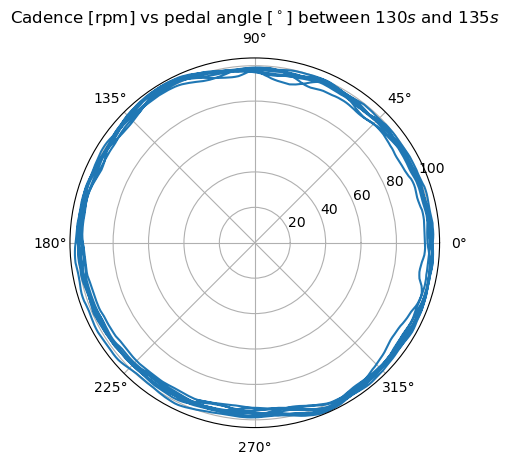

In [38]:
# wattbike(130, 135, cad_lim=[90, 104])
wattbike(130, 135)

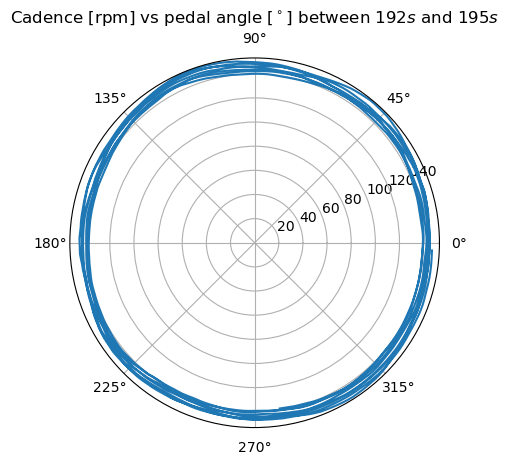

In [39]:
wattbike(192, 195)

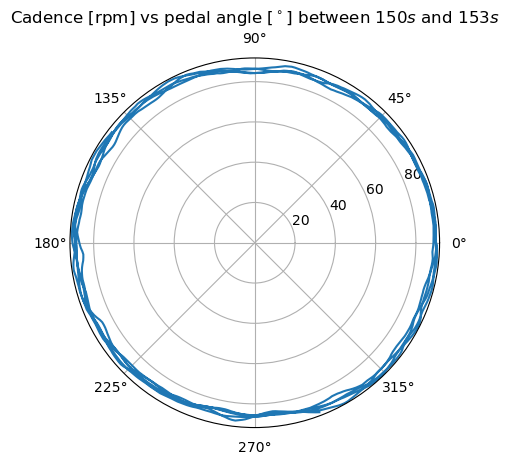

In [40]:
wattbike(150, 153)